In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from skimage.metrics import structural_similarity as ssim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:

class VideoDataset(Dataset):
    def __init__(self, video_root, seq_len=10):
        self.video_root = video_root
        self.seq_len = seq_len
        self.samples = []

        classes = sorted(os.listdir(video_root))
        for cls in classes:
            cls_videos = os.listdir(os.path.join(video_root, cls))
            for vid_file in cls_videos:
                if vid_file.endswith(".pt"):
                    self.samples.append(os.path.join(video_root, cls, vid_file))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path = self.samples[idx]
        video = torch.load(video_path).float()
        video = video[:self.seq_len]
        video = F.interpolate(video, size=(128,128), mode='bilinear', align_corners=False)
        return video

In [ ]:



class ConvLSTMCell(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size=3):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(in_channels + hidden_channels, 4*hidden_channels, kernel_size, padding=padding)
        self.hidden_channels = hidden_channels

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        conv_out = self.conv(combined)
        ci, cf, cg, co = torch.chunk(conv_out, 4, dim=1)
        i = torch.sigmoid(ci)
        f = torch.sigmoid(cf)
        g = torch.tanh(cg)
        o = torch.sigmoid(co)
        c = f*c_prev + i*g
        h = o * torch.tanh(c)
        return h, c

class ConvLSTM(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size=3):
        super().__init__()
        self.cell = ConvLSTMCell(in_channels, hidden_channels, kernel_size)

    def forward(self, x_seq):
        B, T, C, H, W = x_seq.shape
        h = torch.zeros(B, self.cell.hidden_channels, H, W, device=x_seq.device)
        c = torch.zeros(B, self.cell.hidden_channels, H, W, device=x_seq.device)
        outputs = []
        for t in range(T):
            h, c = self.cell(x_seq[:, t], h, c)
            outputs.append(h)
        return torch.stack(outputs, dim=1), (h, c)

class ConvLSTM_Autoencoder(nn.Module):
    def __init__(self, hidden_channels=128):
        super().__init__()
        # Encoder CNN
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, hidden_channels, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # ConvLSTM
        self.convlstm = ConvLSTM(hidden_channels, hidden_channels)
        # Decoder CNN
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_channels, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        B, T, C, H, W = x.shape
        enc_feats = []
        for t in range(T):
            enc_feats.append(self.encoder(x[:, t]))
        enc_feats = torch.stack(enc_feats, dim=1)  

        convlstm_out, _ = self.convlstm(enc_feats)

        out_frames = []
        for t in range(T):
            out_frames.append(self.decoder(convlstm_out[:, t]))
        out = torch.stack(out_frames, dim=1)  
        return out


In [ ]:
video_root = "/kaggle/input/human-activity-recognition-dataset/DataVideo"
seq_len = 10
dataset = VideoDataset(video_root, seq_len=seq_len)
loader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True)
num_epochs = 20

model = ConvLSTM_Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [ ]:
def segment_motion(video, recon, threshold=0.1):
   
    error = torch.abs(video - recon)  
    error_gray = error.mean(dim=2)    
    mask = (error_gray > threshold).float()  
    return mask  

In [ ]:


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    pbar = tqdm(loader)
    for video in pbar:
        video = video.to(device)
        optimizer.zero_grad()
        recon = model(video)
        loss = criterion(recon, video)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Loss: {loss.item():.4f}")
        torch.cuda.empty_cache()


for epoch in range(num_epochs):
    train_one_epoch(model, loader, optimizer, criterion, device)
    torch.save(model.state_dict(), f"autoencoder_epoch_{epoch}.pth")









Loss: 0.0005: 100%|██████████| 1113/1113 [04:02<00:00,  4.59it/s]


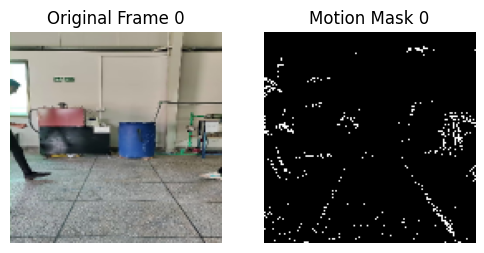

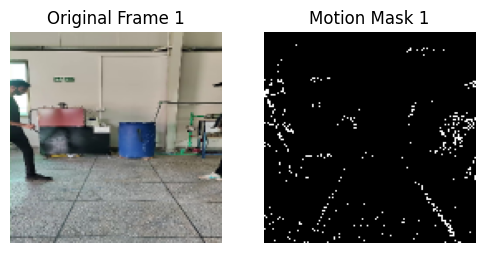

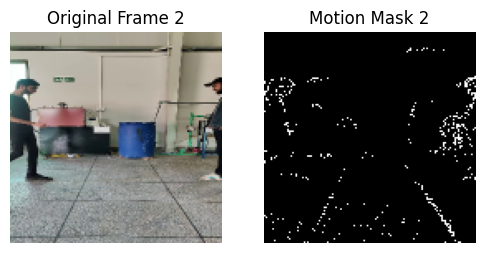

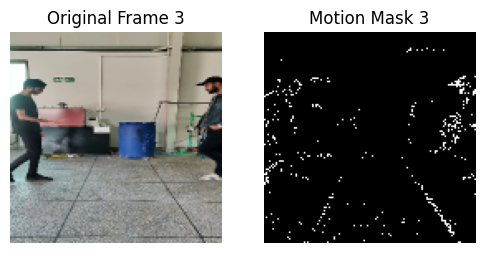

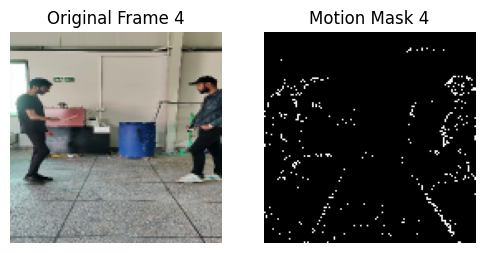

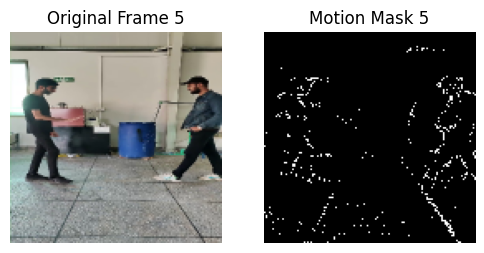

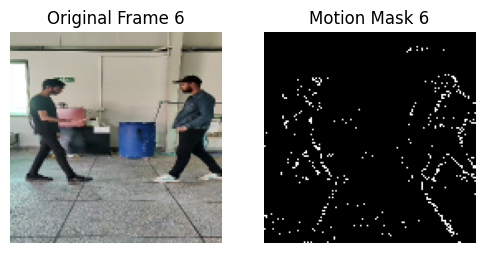

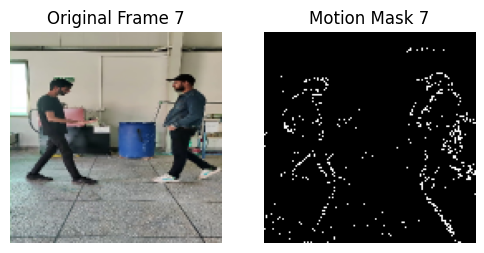

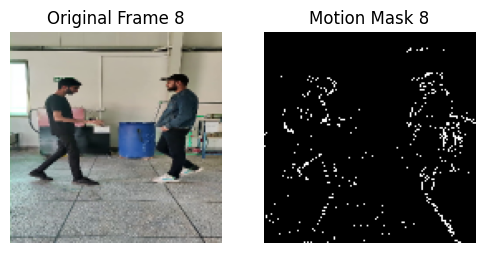

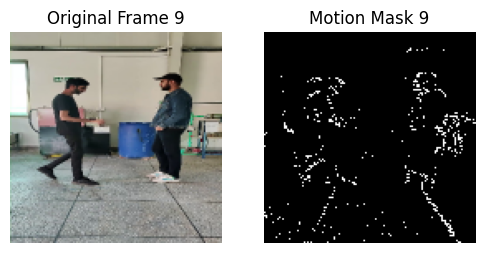

In [ ]:
def visualize_segmentation(video, mask):
    T = video.shape[1]
    for t in range(T):
        fig, axes = plt.subplots(1,2, figsize=(6,3))
        axes[0].imshow(video[0,t].permute(1,2,0).cpu())
        axes[0].set_title(f"Original Frame {t}")
        axes[0].axis('off')
        axes[1].imshow(mask[0,t].cpu(), cmap='gray')
        axes[1].set_title(f"Motion Mask {t}")
        axes[1].axis('off')
        plt.show()


video = next(iter(loader)).to(device)
recon = model(video)
mask = segment_motion(video, recon, threshold=0.1)
visualize_segmentation(video, mask)

In [ ]:


def compute_mse(video, recon):
   
    return F.mse_loss(recon, video).item()


def compute_psnr(video, recon, max_val=1.0):
    
    mse_val = F.mse_loss(recon, video).item()
    if mse_val == 0:
        return float('inf')
    psnr_val = 20 * np.log10(max_val / np.sqrt(mse_val))
    return psnr_val


def compute_ssim(video, recon):
    
    video_np = video.cpu().numpy()
    recon_np = recon.cpu().detach().numpy()
    B, T, C, H, W = video_np.shape
    ssim_total = 0.0
    for b in range(B):
        for t in range(T):
            # SSIM pour image RGB
            ssim_val = ssim(video_np[b,t].transpose(1,2,0),
                            recon_np[b,t].transpose(1,2,0),
                            data_range=1.0, multichannel=True)
            ssim_total += ssim_val
    return ssim_total / (B*T)



mse_val = compute_mse(video, recon)
psnr_val = compute_psnr(video, recon)
ssim_val = compute_ssim(video, recon)

print(f"MSE: {mse_val:.6f}")
print(f"PSNR: {psnr_val:.2f} dB")
print(f"SSIM: {ssim_val:.4f}")


MSE: 81.65
PSNR: 24 dB
SSIM: 0.712
